In [1]:
require(ggplot2)
require(dplyr)
require(tidyr)
require(viridis)  # for a nice colormap
require(stringr)  # for easier string functions in R
require(gridExtra)  # for assembling and aligning multiple plots
require(cowplot)  # for assembling and aligning multiple plots

# homebrewed R code
source('../code/experiment_01_helper_functions.r')

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: viridis
Loading required package: stringr
Loading required package: gridExtra
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: xcms
Loading required package: mzR
Loading required package: Rcpp
Warning message:
In fun(libname, pkgname): mzR has been built against a different Rcpp version (0.12.1)
than is installed on your system (0.12.3). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://

In [2]:
# load fully-processed xcms data of all 27 samples
load('../saved_data/experimental_design_and_sample_table.rdat')
load('../saved_data/xset_samps_filled.rdat')

# load TIC data
load('../saved_data/extracted_TIC_data.rdat')

Loading required package: multtest


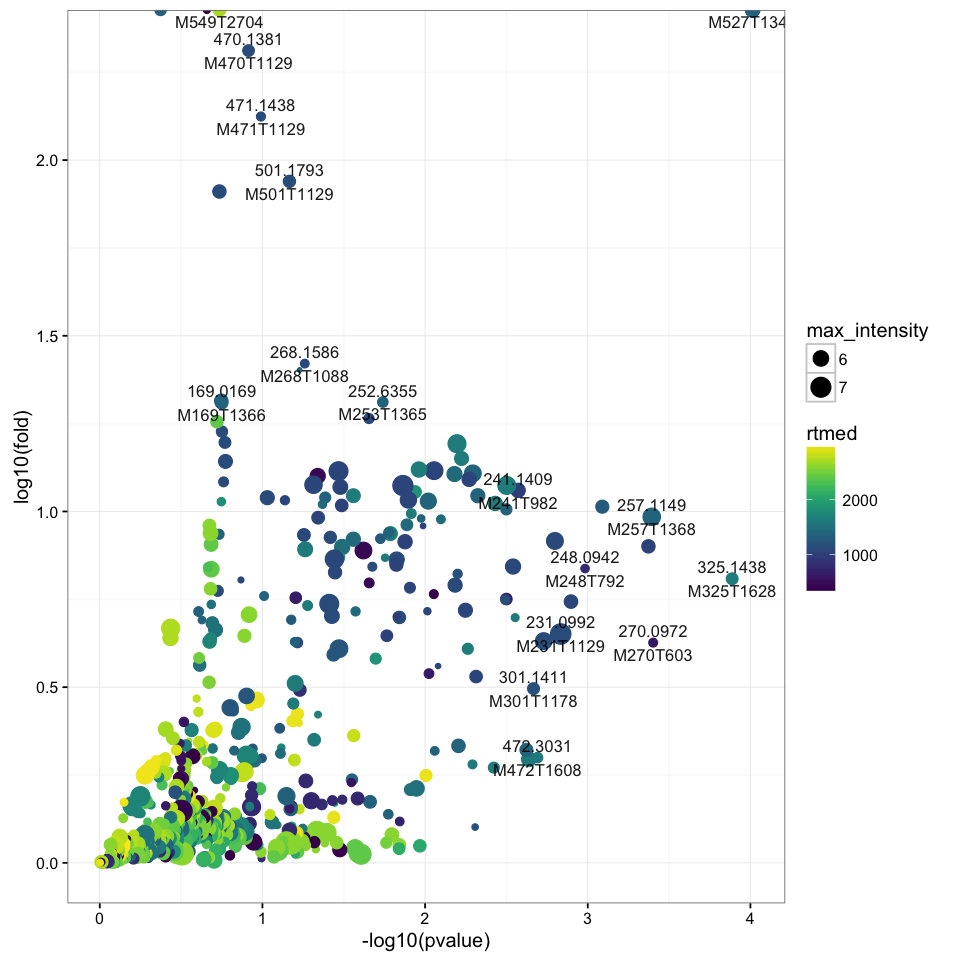

In [3]:
myreport <- do_diffreport_and_plot(xset_samps_filled, class1='18:sup', class2='24:sup', 
                                   max_intensity_cutoff = 5,
                                   label_top_n=25)


show(myreport[['plot']]) 

In [4]:
# simplify the name of the diffReport() to save typing
mydf <- myreport[['reporttab']]

# filter out features as described above and sort by retention time
mydf <- mydf[mydf$fold > 2 & mydf$npeaks <= 6 & mydf$pvalue < 0.1,]
mydf <- mydf[order(mydf$rtmed), ]

# group features by approxiamte retention time
mydf$approx_rt <- sprintf('%.1f', as.numeric(str_extract(mydf$name, '(?<=T)[0-9]*'))/60)

# dplyr is awesome

my_cols <- which(names(mydf) %in% c('name', 'approx_rt', 'mzmed', 'max_intensity', 'fold', '18:sup', '24:sup'))
summary_table <- mydf %>% 
    group_by(approx_rt) %>% 
    filter(max(max_intensity)==max_intensity) %>%
    select(my_cols)

# show the results
summary_table

,name,fold,mzmed,18:sup,24:sup,max_intensity,approx_rt
1,M270T603,4.234065,270.0972,0,0,5.147796,10.1
2,M141T661,5.63363,141.0906,0,3,5.396036,11.0
3,M248T792,6.879113,248.0942,0,3,5.118216,13.2
4,M241T982,11.48311,241.1409,0,3,5.800008,16.4
5,M276T1031,7.956478,276.1291,3,3,5.642816,17.2
6,M283T1055,5.539764,283.0945,0,3,5.662327,17.6
7,M175T1084,6.971318,175.1321,3,3,5.935471,18.1
8,M273T1093,8.243699,273.1098,3,3,6.260167,18.2
9,M231T1129,4.48018,231.0992,3,3,7.128398,18.8
10,M187T1161,5.610282,187.1322,0,3,5.177291,19.4


In [5]:
# plot EICs for filtered features

EICdat <- getEICdf(xset_samps_filled,
                     groupidx=as.character(summary_table$name),
                     sampleidx=sampnames(xset_samps_filled)[sampclass(xset_samps_filled) %in% c('18:sup', '24:sup')]
                     )

16 17 18 19 20 21 


[1] "rt"          "intensity"   "sample"      "mzrange.1"   "mzrange.2"  
[6] "groupname"   "class"       "relative_rt" "mz"

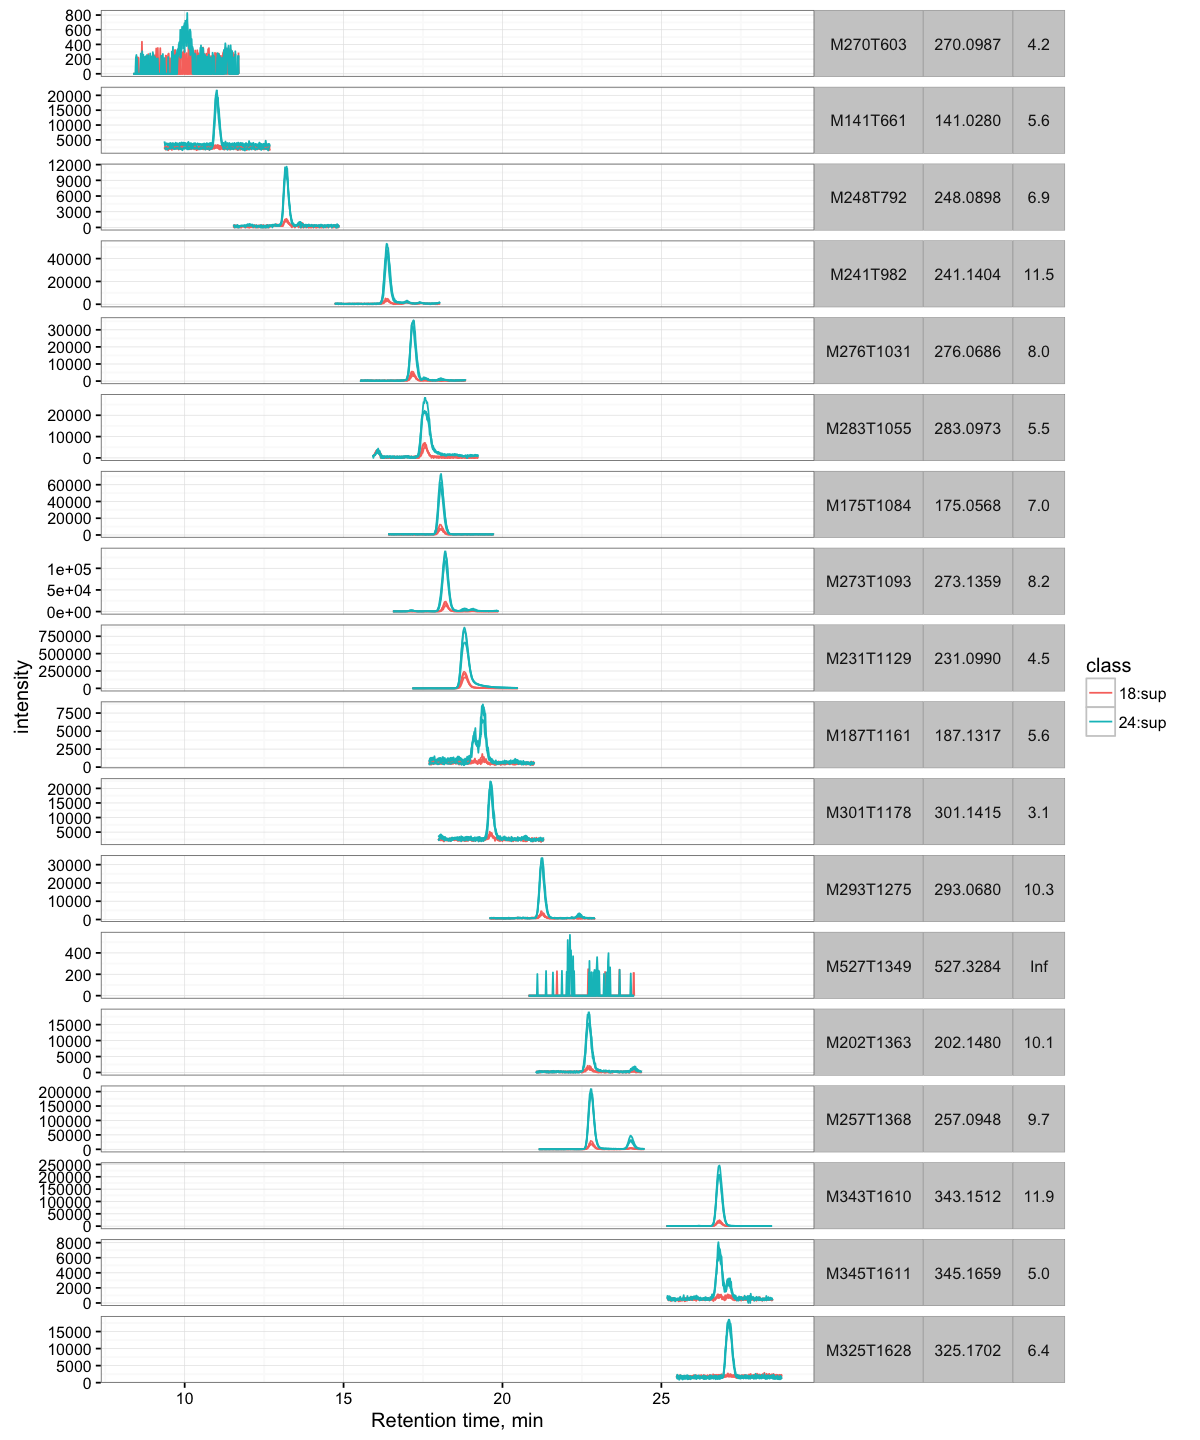

In [6]:
options(repr.plot.width=10, repr.plot.height=12)


my_eics <- EICdat[['eic_data']]
my_eics$mz <- sprintf('%.4f', (my_eics$mzrange.1 + my_eics$mzrange.2) / 2)
names(my_eics)
my_eics_a <- merge(my_eics, summary_table, by.x='groupname', by.y='name')
my_eics_a$fold <- sprintf('%.1f', my_eics_a$fold)

ggplot(data=my_eics_a, aes(x=rt/60, y=intensity, color=class, group=sample)) + 
    geom_line() + 
    facet_grid(groupname + mz + fold~., scales='free_y') +
    xlab('Retention time, min') +
    theme_bw() +
    theme(strip.text.y = element_text(angle=0))

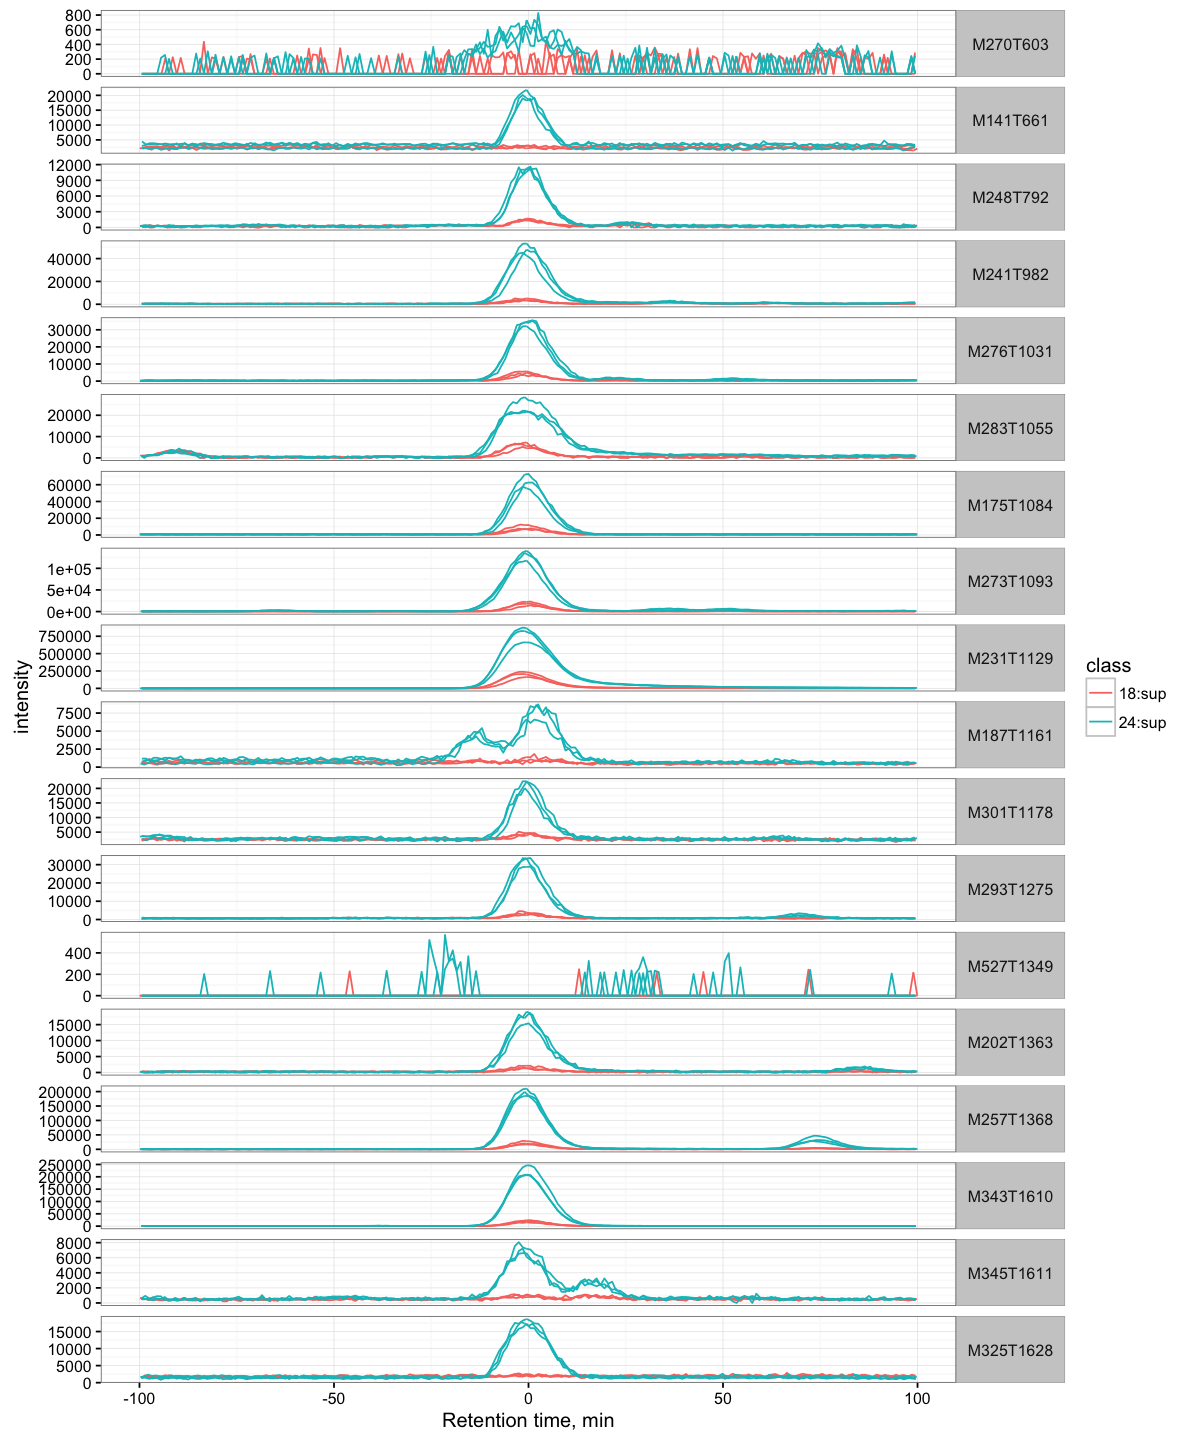

In [7]:
options(repr.plot.width=10, repr.plot.height=12)

EICdat[['plot']] +
    facet_grid(groupname~., scales='free_y') +
    xlab('Retention time, min') +
    theme_bw() +
    theme(strip.text.y = element_text(angle=0))

Warning message:
: Removed 1 rows containing non-finite values (stat_bin).

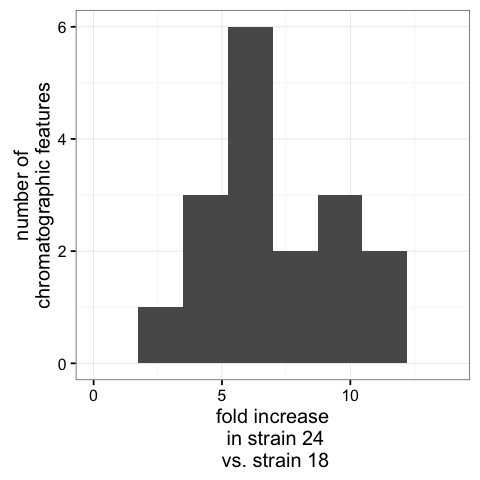

In [14]:
options(repr.plot.width=4, repr.plot.height=4)

ggplot(data=summary_table, aes(x=fold)) +
    geom_histogram(bins=5) +
    theme_bw() + 
    xlab('fold increase\n in strain 24\n vs. strain 18') +
    ylab('number of\nchromatographic features')

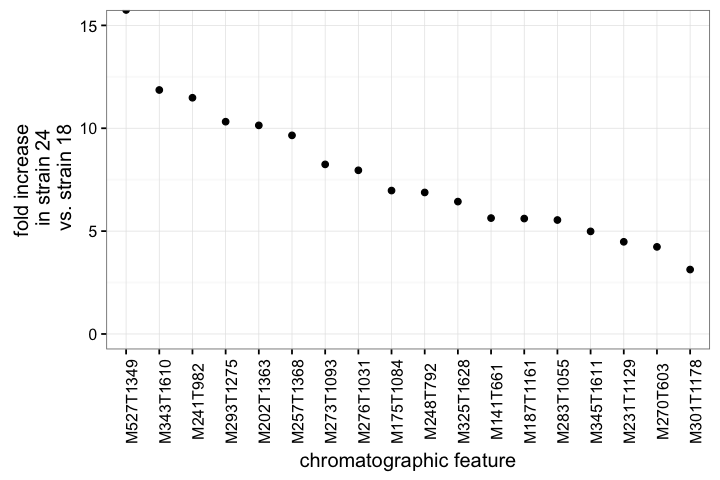

In [13]:
options(repr.plot.width=6, repr.plot.height=4)

ggplot(data=summary_table, aes(x=reorder(name, fold, function(x){-x}, order=T), y=fold)) +
    geom_point() +
    theme_bw() + 
    ylab('fold increase\n in strain 24\n vs. strain 18') +
    xlab('chromatographic feature') +
    theme(axis.text.x = element_text(angle=90)) +
    ylim(0, 15)